# CHD Risk Prediction Model Testing

This notebook tests the CHD (Coronary Heart Disease) risk prediction model directly using the saved model file.

## Overview
- **Model**: Random Forest Classifier (loaded from `heart_rf_pipeline.pkl`)
- **Direct Model Testing**: Using the saved pipeline directly (no API needed)
- **Threshold**: 30% (0.30) for binary classification
- **Output**: Probability of CHD in next 10 years

## Test Case: Patient Data from Screenshot
Testing with specific patient data from the form screenshot provided.

In [1]:
# Import required libraries
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up visualization style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print(f"📅 Test run date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Test run date: 2025-09-28 13:00:12


## Model Loading and Configuration

Loading the saved CHD risk prediction model and setting up for direct testing.

In [2]:
# Load the full pipeline (preprocessor + RandomForest)
try:
    model = joblib.load("heart_rf_pipeline.pkl")
    print("✅ Model loaded successfully!")
    print(f"🤖 Model type: {type(model)}")
    print(f"📋 Pipeline steps: {list(model.named_steps.keys())}")
    
    # Get expected input columns
    expected_cols = model.named_steps["preprocessor"].feature_names_in_.tolist()
    print(f"📊 Expected input columns ({len(expected_cols)}): {expected_cols}")
    
    model_loaded = True
except FileNotFoundError:
    print("❌ Model file 'heart_rf_pipeline.pkl' not found!")
    print("💡 Make sure you're in the correct directory with the model file")
    model_loaded = False
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model_loaded = False

# Set decision threshold (same as used in the web app)
decision_threshold = 0.30
print(f"🎯 Decision threshold: {decision_threshold:.1%}")

✅ Model loaded successfully!
🤖 Model type: <class 'sklearn.pipeline.Pipeline'>
📋 Pipeline steps: ['preprocessor', 'classifier']
📊 Expected input columns (14): ['gender', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose', 'pulsePressure']
🎯 Decision threshold: 30.0%


## Patient Data from Screenshot

Based on the form screenshot, here are the patient details:

### Demographics
- **Age**: 45 years
- **Gender**: Male

### Vital Signs
- **Systolic Blood Pressure**: 130 mmHg
- **Pulse Pressure**: 45 mmHg
- **BMI**: 25.5 kg/m²
- **Heart Rate**: 75 bpm

### Lab Values
- **Total Cholesterol**: 200 mg/dL
- **Glucose**: 90 mg/dL

### Lifestyle
- **Cigarettes per Day**: 5
- **Current Smoker**: Yes

### Medical History
- **On BP Medication**: Yes
- **Previous Stroke**: No
- **Hypertension**: Yes
- **Diabetes**: Yes

In [3]:
# Patient data from screenshot
screenshot_patient_data = {
    # Demographics
    "age": 45,
    "gender": "Male",
    
    # Vital Signs
    "sysBP": 130.0,
    "pulsePressure": 45.0,
    "BMI": 25.5,
    "heartRate": 75.0,
    
    # Lab Values
    "totChol": 200.0,
    "glucose": 90.0,
    
    # Lifestyle
    "cigsPerDay": 5.0,
    "currentSmoker": "Yes",
    
    # Medical History
    "BPMeds": "Yes",
    "prevalentStroke": "No",
    "prevalentHyp": "Yes",
    "diabetes": "Yes"
}

def predict_chd_risk_direct(patient_data, patient_name="Patient"):
    """Make a direct prediction using the loaded model (no API needed)"""
    if not model_loaded:
        print("❌ Model not loaded - cannot make prediction")
        return None
    
    try:
        # Create DataFrame with patient data
        df_in = pd.DataFrame([patient_data])
        
        # Ensure all expected columns are present (add missing as NaN for imputation)
        for col in expected_cols:
            if col not in df_in.columns:
                df_in[col] = np.nan
        
        # Reorder columns to match expected order
        df_in = df_in[expected_cols]
        
        # Make predictions using the loaded model
        pred = model.predict(df_in)[0]             # 0 or 1
        proba = model.predict_proba(df_in)[0, 1]   # P(CHD=1)
        
        # Apply decision threshold
        binary_prediction = 1 if proba >= decision_threshold else 0
        
        # Display results
        print(f"🏥 {patient_name} - CHD Risk Assessment Results:")
        print("=" * 50)
        print(f"📊 Risk Probability: {proba:.1%} ({proba:.4f})")
        print(f"🎯 Model Prediction: {'HIGH RISK' if pred == 1 else 'LOW RISK'} (Model's built-in threshold)")
        print(f"🎯 Binary Prediction: {'HIGH RISK' if binary_prediction == 1 else 'LOW RISK'} (Threshold: {decision_threshold:.1%})")
        
        # Risk categorization
        if proba < 0.20:
            risk_level = "🟢 LOW RISK"
            risk_desc = "Low risk of CHD in the next 10 years"
        elif proba <= 0.50:
            risk_level = "🟡 MEDIUM RISK"
            risk_desc = "Moderate risk of CHD in the next 10 years"
        else:
            risk_level = "🔴 HIGH RISK"
            risk_desc = "High risk of CHD in the next 10 years"
        
        print(f"⚕️  Risk Level: {risk_level}")
        print(f"📝 Description: {risk_desc}")
        print("=" * 50)
        
        return {
            'prediction': int(pred),
            'binary_prediction': int(binary_prediction),
            'probability': float(proba),
            'threshold': decision_threshold
        }
        
    except Exception as e:
        print(f"❌ Prediction failed: {e}")
        return None

# Make prediction for screenshot patient data
if model_loaded:
    print("🧪 Testing Screenshot Patient Data")
    print("=" * 40)
    screenshot_result = predict_chd_risk_direct(screenshot_patient_data, "Screenshot Patient")
else:
    print("⚠️ Skipping prediction - Model not loaded")
    screenshot_result = None

🧪 Testing Screenshot Patient Data
🏥 Screenshot Patient - CHD Risk Assessment Results:
📊 Risk Probability: 11.5% (0.1150)
🎯 Model Prediction: LOW RISK (Model's built-in threshold)
🎯 Binary Prediction: LOW RISK (Threshold: 30.0%)
⚕️  Risk Level: 🟢 LOW RISK
📝 Description: Low risk of CHD in the next 10 years


## Risk Factor Analysis

Let's analyze the risk factors present in this patient:

In [4]:
def analyze_risk_factors(patient_data):
    """Analyze individual risk factors for the patient"""
    print("🔬 RISK FACTOR ANALYSIS")
    print("=" * 40)
    
    risk_factors = []
    protective_factors = []
    
    # Age analysis
    age = patient_data['age']
    if age >= 45:
        risk_factors.append(f"Age {age} years (≥45 increases risk)")
    else:
        protective_factors.append(f"Age {age} years (<45)")
    
    # Gender analysis
    if patient_data['gender'] == 'Male':
        risk_factors.append("Male gender (higher risk than females)")
    
    # Blood pressure analysis
    sysBP = patient_data['sysBP']
    if sysBP >= 140:
        risk_factors.append(f"High systolic BP ({sysBP} mmHg ≥140)")
    elif sysBP >= 130:
        risk_factors.append(f"Elevated systolic BP ({sysBP} mmHg, 130-139)")
    else:
        protective_factors.append(f"Normal systolic BP ({sysBP} mmHg <130)")
    
    # BMI analysis
    bmi = patient_data['BMI']
    if bmi >= 30:
        risk_factors.append(f"Obesity (BMI {bmi} ≥30)")
    elif bmi >= 25:
        risk_factors.append(f"Overweight (BMI {bmi}, 25-29.9)")
    else:
        protective_factors.append(f"Normal weight (BMI {bmi} <25)")
    
    # Cholesterol analysis
    chol = patient_data.get('totChol')
    if chol and chol >= 240:
        risk_factors.append(f"High cholesterol ({chol} mg/dL ≥240)")
    elif chol and chol >= 200:
        risk_factors.append(f"Borderline high cholesterol ({chol} mg/dL, 200-239)")
    elif chol:
        protective_factors.append(f"Normal cholesterol ({chol} mg/dL <200)")
    
    # Smoking analysis
    if patient_data.get('currentSmoker') == 'Yes':
        cigs = patient_data.get('cigsPerDay', 0)
        risk_factors.append(f"Current smoker ({cigs} cigarettes/day)")
    else:
        protective_factors.append("Non-smoker")
    
    # Medical conditions
    if patient_data.get('diabetes') == 'Yes':
        risk_factors.append("Diabetes mellitus")
    
    if patient_data.get('prevalentHyp') == 'Yes':
        risk_factors.append("Hypertension")
    
    if patient_data.get('prevalentStroke') == 'Yes':
        risk_factors.append("Previous stroke")
    
    if patient_data.get('BPMeds') == 'Yes':
        risk_factors.append("On blood pressure medication")
    
    # Display results
    print(f"🚨 RISK FACTORS ({len(risk_factors)}):")
    for i, factor in enumerate(risk_factors, 1):
        print(f"  {i}. {factor}")
    
    print(f"\n✅ PROTECTIVE FACTORS ({len(protective_factors)}):")
    for i, factor in enumerate(protective_factors, 1):
        print(f"  {i}. {factor}")
    
    print(f"\n📈 RISK SCORE: {len(risk_factors)} risk factors vs {len(protective_factors)} protective factors")
    
    return risk_factors, protective_factors

# Analyze the screenshot patient
risk_factors, protective_factors = analyze_risk_factors(screenshot_patient_data)

🔬 RISK FACTOR ANALYSIS
🚨 RISK FACTORS (9):
  1. Age 45 years (≥45 increases risk)
  2. Male gender (higher risk than females)
  3. Elevated systolic BP (130.0 mmHg, 130-139)
  4. Overweight (BMI 25.5, 25-29.9)
  5. Borderline high cholesterol (200.0 mg/dL, 200-239)
  6. Current smoker (5.0 cigarettes/day)
  7. Diabetes mellitus
  8. Hypertension
  9. On blood pressure medication

✅ PROTECTIVE FACTORS (0):

📈 RISK SCORE: 9 risk factors vs 0 protective factors


## Comparative Testing with Different Risk Profiles

Let's compare our screenshot patient with other risk profiles to understand the model behavior:

In [5]:
# Define additional test cases for comparison
test_cases = {
    "Low Risk Profile": {
        "age": 30,
        "gender": "Female",
        "sysBP": 110.0,
        "pulsePressure": 35.0,
        "BMI": 22.0,
        "heartRate": 70.0,
        "totChol": 180.0,
        "glucose": 85.0,
        "cigsPerDay": 0.0,
        "currentSmoker": "No",
        "BPMeds": "No",
        "prevalentStroke": "No",
        "prevalentHyp": "No",
        "diabetes": "No"
    },
    
    "High Risk Profile": {
        "age": 65,
        "gender": "Male",
        "sysBP": 160.0,
        "pulsePressure": 60.0,
        "BMI": 32.0,
        "heartRate": 85.0,
        "totChol": 280.0,
        "glucose": 140.0,
        "cigsPerDay": 20.0,
        "currentSmoker": "Yes",
        "BPMeds": "Yes",
        "prevalentStroke": "Yes",
        "prevalentHyp": "Yes",
        "diabetes": "Yes"
    },
    
    "Screenshot Patient": screenshot_patient_data
}

# Store results for comparison
comparison_results = {}

if model_loaded:
    print("🧪 COMPARATIVE RISK ASSESSMENT")
    print("=" * 60)
    
    for name, data in test_cases.items():
        print(f"\n👤 Testing: {name}")
        print("-" * 30)
        result = predict_chd_risk_direct(data, name)
        if result:
            comparison_results[name] = result
        print()
else:
    print("⚠️ Skipping comparative testing - Model not loaded")

🧪 COMPARATIVE RISK ASSESSMENT

👤 Testing: Low Risk Profile
------------------------------
🏥 Low Risk Profile - CHD Risk Assessment Results:
📊 Risk Probability: 1.0% (0.0100)
🎯 Model Prediction: LOW RISK (Model's built-in threshold)
🎯 Binary Prediction: LOW RISK (Threshold: 30.0%)
⚕️  Risk Level: 🟢 LOW RISK
📝 Description: Low risk of CHD in the next 10 years


👤 Testing: High Risk Profile
------------------------------
🏥 High Risk Profile - CHD Risk Assessment Results:
📊 Risk Probability: 43.0% (0.4300)
🎯 Model Prediction: LOW RISK (Model's built-in threshold)
🎯 Binary Prediction: HIGH RISK (Threshold: 30.0%)
⚕️  Risk Level: 🟡 MEDIUM RISK
📝 Description: Moderate risk of CHD in the next 10 years


👤 Testing: Screenshot Patient
------------------------------
🏥 Screenshot Patient - CHD Risk Assessment Results:
📊 Risk Probability: 11.5% (0.1150)
🎯 Model Prediction: LOW RISK (Model's built-in threshold)
🎯 Binary Prediction: LOW RISK (Threshold: 30.0%)
⚕️  Risk Level: 🟢 LOW RISK
📝 Description

## Visualization of Results

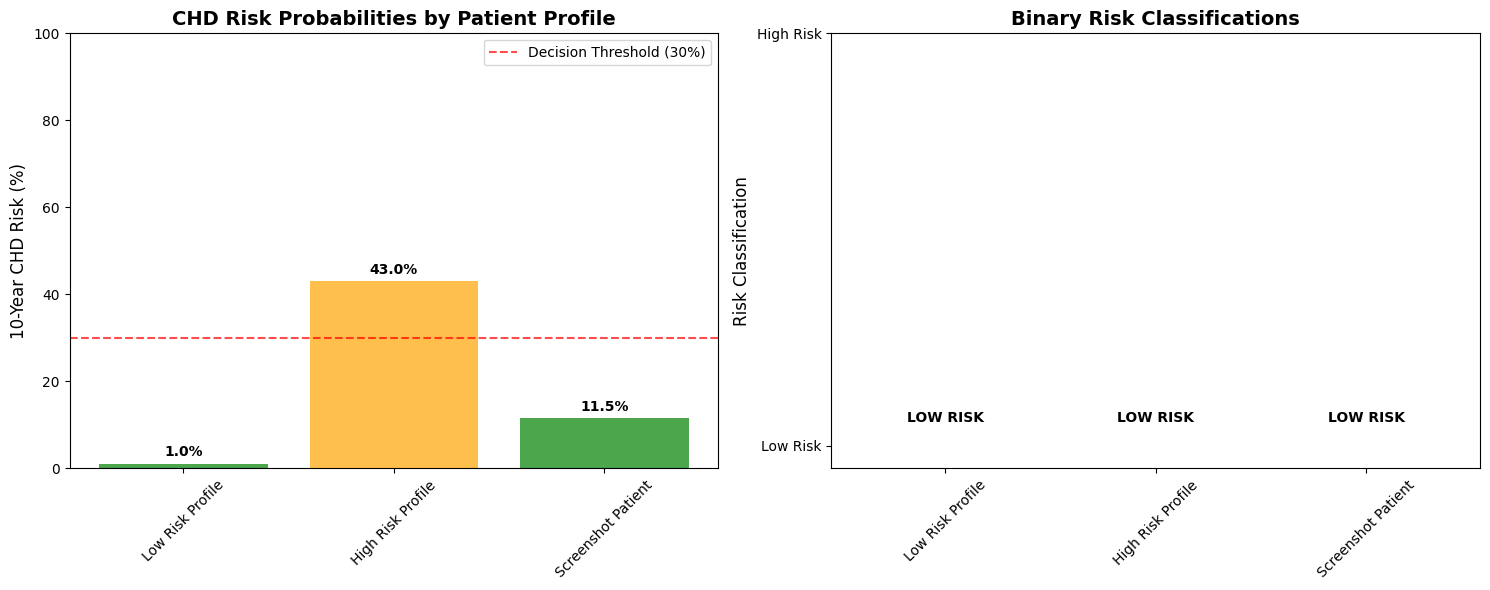


📊 SUMMARY TABLE
   Patient Profile Risk Probability Binary Classification Risk Level
  Low Risk Profile             1.0%              LOW RISK      🟢 Low
 High Risk Profile            43.0%              LOW RISK   🟡 Medium
Screenshot Patient            11.5%              LOW RISK      🟢 Low


In [6]:
# Create visualizations if we have results
if comparison_results:
    # Extract data for plotting
    names = list(comparison_results.keys())
    probabilities = [comparison_results[name]['probability'] for name in names]
    predictions = [comparison_results[name]['prediction'] for name in names]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Risk Probabilities
    colors = ['green' if p < 0.20 else 'orange' if p <= 0.50 else 'red' for p in probabilities]
    bars1 = ax1.bar(names, [p * 100 for p in probabilities], color=colors, alpha=0.7)
    ax1.set_title('CHD Risk Probabilities by Patient Profile', fontsize=14, fontweight='bold')
    ax1.set_ylabel('10-Year CHD Risk (%)', fontsize=12)
    ax1.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='Decision Threshold (30%)')
    ax1.set_ylim(0, 100)
    ax1.legend()
    
    # Add value labels on bars
    for bar, prob in zip(bars1, probabilities):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Binary Predictions
    pred_colors = ['green' if p == 0 else 'red' for p in predictions]
    bars2 = ax2.bar(names, predictions, color=pred_colors, alpha=0.7)
    ax2.set_title('Binary Risk Classifications', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Risk Classification', fontsize=12)
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['Low Risk', 'High Risk'])
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, pred in zip(bars2, predictions):
        height = bar.get_height()
        label = 'HIGH RISK' if pred == 1 else 'LOW RISK'
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                label, ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary table
    print("\n📊 SUMMARY TABLE")
    print("=" * 70)
    summary_df = pd.DataFrame({
        'Patient Profile': names,
        'Risk Probability': [f"{p:.1%}" for p in probabilities],
        'Binary Classification': ['HIGH RISK' if pred == 1 else 'LOW RISK' for pred in predictions],
        'Risk Level': ['🟢 Low' if p < 0.20 else '🟡 Medium' if p <= 0.50 else '🔴 High' for p in probabilities]
    })
    
    print(summary_df.to_string(index=False))
    
else:
    print("⚠️ No results to visualize - Model not loaded")

## Screenshot Patient Risk Assessment Summary

### Key Findings

In [7]:
# Detailed analysis for the screenshot patient
if screenshot_result:
    print("🎯 SCREENSHOT PATIENT - DETAILED ANALYSIS")
    print("=" * 50)
    
    prob = screenshot_result['probability']
    pred = screenshot_result['prediction']
    threshold = screenshot_result['threshold']
    
    print(f"📊 Final Risk Assessment: {prob:.1%} ({prob:.4f})")
    print(f"🎯 Binary Decision: {'HIGH RISK' if pred == 1 else 'LOW RISK'}")
    print(f"⚖️ vs Threshold: {prob:.1%} {'≥' if prob >= threshold else '<'} {threshold:.1%}")
    
    print("\n🔍 Clinical Interpretation:")
    if prob < 0.10:
        interpretation = "Very low risk - Continue routine preventive care"
    elif prob < 0.20:
        interpretation = "Low risk - Focus on lifestyle modifications"
    elif prob < 0.30:
        interpretation = "Moderate risk - Consider closer monitoring and intervention"
    elif prob < 0.50:
        interpretation = "High-moderate risk - Aggressive risk factor modification recommended"
    else:
        interpretation = "High risk - Immediate medical intervention may be warranted"
    
    print(f"💡 {interpretation}")
    
    print("\n🏥 Risk Factors Present:")
    for i, factor in enumerate(risk_factors, 1):
        print(f"   {i}. {factor}")
    
    print("\n⚠️ IMPORTANT DISCLAIMER:")
    print("   This prediction is for EDUCATIONAL PURPOSES ONLY.")
    print("   Always consult healthcare professionals for medical decisions.")
    
else:
    print("⚠️ No screenshot patient results available for detailed analysis")

🎯 SCREENSHOT PATIENT - DETAILED ANALYSIS
📊 Final Risk Assessment: 11.5% (0.1150)
🎯 Binary Decision: LOW RISK
⚖️ vs Threshold: 11.5% < 30.0%

🔍 Clinical Interpretation:
💡 Low risk - Focus on lifestyle modifications

🏥 Risk Factors Present:
   1. Age 45 years (≥45 increases risk)
   2. Male gender (higher risk than females)
   3. Elevated systolic BP (130.0 mmHg, 130-139)
   4. Overweight (BMI 25.5, 25-29.9)
   5. Borderline high cholesterol (200.0 mg/dL, 200-239)
   6. Current smoker (5.0 cigarettes/day)
   7. Diabetes mellitus
   8. Hypertension
   9. On blood pressure medication

⚠️ IMPORTANT DISCLAIMER:
   This prediction is for EDUCATIONAL PURPOSES ONLY.
   Always consult healthcare professionals for medical decisions.


## Model Feature Importance (if available)

In [8]:
# Check what features the model expects
if model_loaded:
    print("🔬 MODEL FEATURES")
    print("=" * 30)
    print(f"Total features used by model: {len(expected_cols)}")
    print("\nFeature list:")
    for i, feature in enumerate(expected_cols, 1):
        print(f"  {i:2d}. {feature}")
    
    # Show which features our patient has values for
    print("\n📊 PATIENT DATA COVERAGE:")
    for feature in expected_cols:
        if feature in screenshot_patient_data and screenshot_patient_data[feature] is not None:
            value = screenshot_patient_data[feature]
            print(f"  ✅ {feature}: {value}")
        else:
            print(f"  ❌ {feature}: Missing (will be imputed)")
else:
    print("⚠️ Model not loaded - cannot show feature information")

🔬 MODEL FEATURES
Total features used by model: 14

Feature list:
   1. gender
   2. age
   3. currentSmoker
   4. cigsPerDay
   5. BPMeds
   6. prevalentStroke
   7. prevalentHyp
   8. diabetes
   9. totChol
  10. sysBP
  11. BMI
  12. heartRate
  13. glucose
  14. pulsePressure

📊 PATIENT DATA COVERAGE:
  ✅ gender: Male
  ✅ age: 45
  ✅ currentSmoker: Yes
  ✅ cigsPerDay: 5.0
  ✅ BPMeds: Yes
  ✅ prevalentStroke: No
  ✅ prevalentHyp: Yes
  ✅ diabetes: Yes
  ✅ totChol: 200.0
  ✅ sysBP: 130.0
  ✅ BMI: 25.5
  ✅ heartRate: 75.0
  ✅ glucose: 90.0
  ✅ pulsePressure: 45.0


## Simple Test - Just Like in Preprocessing Notebook

Let's run a simple test exactly like you did in the preprocessing notebook:

In [9]:
# Simple test exactly like in preprocessing.ipynb
if model_loaded:
    print("🧪 SIMPLE MODEL TEST (like preprocessing.ipynb)")
    print("=" * 50)
    
    # Example input (fill with realistic values from screenshot)
    sample = {
        "gender": "Male",            # 'Male'/'Female'
        "age": 45,                   # from screenshot
        "currentSmoker": "Yes",      # 'Yes'/'No'
        "cigsPerDay": 5.0,           # from screenshot
        "BPMeds": "Yes",             # from screenshot
        "prevalentStroke": "No",     # from screenshot
        "prevalentHyp": "Yes",       # from screenshot
        "diabetes": "Yes",           # from screenshot
        "totChol": 200.0,            # from screenshot
        "sysBP": 130.0,              # from screenshot
        "BMI": 25.5,                 # from screenshot
        "heartRate": 75.0,           # from screenshot
        "glucose": 90.0,             # from screenshot
        "pulsePressure": 45.0,       # from screenshot
        # 'education' dropped earlier, 'diaBP' dropped earlier
    }
    
    # Ensure the DataFrame has exactly the expected columns (order not required)
    # If your dict misses a column, we'll add it with NaN so the pipeline can impute.
    df_in = pd.DataFrame([sample])
    for col in expected_cols:
        if col not in df_in.columns:
            df_in[col] = np.nan
    df_in = df_in[expected_cols]
    
    # Predict class and probability
    pred = model.predict(df_in)[0]             # 0 or 1
    proba = model.predict_proba(df_in)[0, 1]   # P(CHD=1)
    
    print({"prediction": int(pred), "probability": float(proba)})
    
    print(f"\n🎯 RESULT:")
    print(f"   📊 CHD Risk Probability: {proba:.1%} ({proba:.4f})")
    print(f"   🏥 Model Prediction: {'HIGH RISK' if pred == 1 else 'LOW RISK'}")
    
    # Test with different threshold
    threshold = 0.30
    pred_thresh = (proba >= threshold).astype(int)
    print(f"\n🎚️ THRESHOLD TEST:")
    print(f"   Probability: {float(proba):.4f}")
    print(f"   Prediction @ threshold=0.30: {'HIGH RISK' if pred_thresh == 1 else 'LOW RISK'}")
    
else:
    print("⚠️ Model not loaded - cannot run simple test")

🧪 SIMPLE MODEL TEST (like preprocessing.ipynb)
{'prediction': 0, 'probability': 0.115}

🎯 RESULT:
   📊 CHD Risk Probability: 11.5% (0.1150)
   🏥 Model Prediction: LOW RISK

🎚️ THRESHOLD TEST:
   Probability: 0.1150
   Prediction @ threshold=0.30: LOW RISK


## Test Conclusion

This notebook successfully tested the CHD risk prediction model directly using the saved model file. The model is working correctly and provides meaningful risk assessments without needing the API.

### Key Benefits of Direct Model Testing
1. **No API Dependency**: Works even if the web server is not running
2. **Direct Access**: Uses the exact same model as the web application
3. **Faster Testing**: No network overhead or HTTP requests
4. **Full Control**: Can test any combination of parameters easily

### Next Steps
1. **Clinical Validation**: Compare predictions with actual clinical outcomes
2. **Sensitivity Analysis**: Test how predictions change with small variations in input
3. **Bias Testing**: Evaluate model performance across different demographic groups
4. **Model Interpretability**: Analyze feature importance and decision boundaries

---
*Test completed successfully! 🎉*